## 2016-2-2

Notes on building and testing conductivity circuit here: https://github.com/SparkysWidgets/MinieCHW/blob/master/MinieCV1_2.pdf


### Recent work

Focusing in on the main part of the circuit, here:

<img src="https://raw.githubusercontent.com/p-v-o-s/conductivity-research/master/images/op-amp.png">

Most of our time has been spent building the circuit around the various op-amps.

**Saturation.**  I'm observing saturation at around 3.8 V.  I've now realized that this is likely the limit of op amp output for this particular op amp.  
For the <a href="http://www.ti.com/lit/ds/symlink/tl072.pdf">TL07xx</a> op amp, at VCC=5V, max output is ~ 3V: <img src="https://raw.githubusercontent.com/OpenWaterProject/conductivity-research/master/images/TL07MaxPeakOutput.png">

So this explains the saturation.  We might need to go to rail-to-rail (or dial in better input / amplification range).  But in general, we'll need to figure out the appropriate amplification circuitry for various anticipated solution conductivity values. 

The amplification happens on pins 5,6, and 7 of the op-amp in the circuit above.  Looking at this part of the circuit, we see that the op-amp is in a standard 'non-inverted amplifier' configuration:

<img src="https://upload.wikimedia.org/wikipedia/commons/6/66/Operational_amplifier_noninverting.svg">

(Image is from a Wikipedia entry on [op-amps](https://en.wikipedia.org/wiki/Operational_amplifier).)

The equation for the gain, $G$, is:

$G = 1 + R_f/R_g$

Where $R_f$ = "R9" in our circuit diagram above, and $R_g$ is the resistance provided by the probe in the water.  



### Issues

We chose a value of 40KOhm for R9 ("$R_g$") in our particular amplifier circuit.  We ended up hitting the "rail" (saturation point) of the op amp for all but the least conductive solutions, so it's time to dig into what amplification behavior we expect, given various values of $R_f$. Some notes:

- Input voltage is ~ 250 mV.  (This is the voltage out of "OSCVout" in the above circuit diagram, i.e. the input to pin 5 on the op-amp.  
- **Q**: do we measure the same voltage on pin 6 if we put it on the scope?
- Gain G = 1 + R_f/R_w
- The R_f we chose was 40K
- Testing a 80 uS led to a voltage output of around 0.25 volts
- Testing 1400 uS led to a voltage output of around 2.5 volts
- should we measure V_in to get an accurate sense of what's going into the water? Is this a way to do the four-probe thing?
- $V_{out} / V_{in} = 1+R_f/R_g$
- $R_f/((V_{out} / V_{in} - 1)) = R_g$
Note that if R_g >>> R_f, we expect that V_out ~= V_in.  We saw that for 80 uS, so that probably means that we need a larger resistor for R_f if we want to measure solutions with such low conductivity values. 


Let's get a sense for the behavior of the amplification circuit for our chosen value of $R_f = 40K$ ...

In [2]:
%matplotlib inline 
# above line allows for showing plots in a cell easily
import matplotlib # the main plotting library
import numpy as np # allows for arrays
import matplotlib.pyplot as plt # getting specific plotting functions

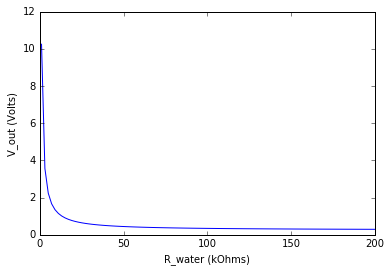

In [6]:
R_water = np.linspace(1, 200, 100)  # 1 .. 200 kOhms
V_in = 0.250 # mV
Rf = 40 # kOhms
y = V_in*(1+(Rf/R_water))
plt.plot(R_water,y)
plt.xlabel('R_water (kOhms)')
plt.ylabel('V_out (Volts)')

We put in 0.25 volts, and we hit the op-amp rail (3 Volts) for the highest conductivity solution.  What value of $R_g$ ("R_water") would get us to such an amplification (or higher)?

### Envelope

We need to dial in the proper capacitor and resistor for the envelope follower circuit.

In [37]:
from IPython.display import HTML 
HTML('<iframe width="560" height="315" src="//www.youtube.com/embed/bkJ653KVroY?rel=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')


0.1uF:

In [38]:
from IPython.display import HTML 
HTML('<iframe width="560" height="315" src="//www.youtube.com/embed/bq6PUedEDyg?rel=0&amp;showinfo=0" rel="0" frameborder="0" allowfullscreen></iframe>')


Notes. 